In [1]:
import librosa
import numpy as np
#import pandas as pd
from keras.layers import Dense
from keras.models import Sequential
from pydub import AudioSegment
from scipy import signal
from sklearn import preprocessing

In [2]:
pathAudio = '/home/stud/m/mh361/share/sample-same-with-diff-genre/'
files = librosa.util.find_files(pathAudio, ext=['mp3'])

song_lounge_it = []
song_tuesday_night = []
song_kingtop = []
for file in files:
    if 'Nutmeg' in file:
        song_lounge_it.append(file)
    if 'John' in file:
        song_tuesday_night.append(file)
    if 'Holizna' in file:
        song_kingtop.append(file)
song_lounge_it = sorted(song_lounge_it, key=lambda x: int(x.split('_')[-1].split('.')[0]))
song_tuesday_night = sorted(song_tuesday_night, key=lambda x: int(x.split('_')[-1].split('.')[0]))
song_kingtop = sorted(song_kingtop, key=lambda x: int(x.split('_')[-1].split('.')[0]))

In [3]:
print(len(song_lounge_it))
print(len(song_tuesday_night))
print(len(song_kingtop))

124
44
69


In [4]:
full_songs = []
full_songs.extend(song_lounge_it)
full_songs.extend(song_tuesday_night)
full_songs.extend(song_kingtop)
len(full_songs)

237

In [5]:
from matplotlib import pyplot as plt
def normalize_sample(sample):
    array_of_samples = sample.get_array_of_samples()
    np_arr = np.array(array_of_samples)
    np_arr = np_arr.reshape(1, -1)
    return preprocessing.normalize(np_arr)
# todo: Check smallest sample!!
samples = []
samples_sec_canal = []
for file_name in full_songs:
    sample = AudioSegment.from_mp3(file_name)
    mono_samples = sample.split_to_mono()
    normalized_sample = normalize_sample(mono_samples[0])[0]
    #resampled_sample = signal.resample(normalized_sample, 1000)
    samples.append(normalized_sample)
    normalized_sample_sec_canal = normalize_sample(mono_samples[1])[0]
    #resampled_sample_sec_canal = signal.resample(normalized_sample_sec_canal, 1000)
    samples_sec_canal.append(normalized_sample_sec_canal)

In [6]:
min(map(len, samples))

8555

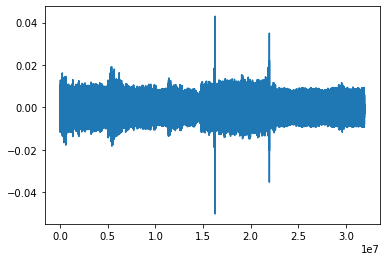

In [7]:
import itertools

plt.plot(list(itertools.chain.from_iterable(samples)))
plt.show()

In [8]:
len(samples)

237

In [9]:
# todo: Check smallest sample!!
samples = []
samples_sec_canal = []
for file_name in full_songs:
    sample = AudioSegment.from_mp3(file_name)
    mono_samples = sample.split_to_mono()
    normalized_sample = normalize_sample(mono_samples[0])[0]
    resampled_sample = signal.resample(normalized_sample, int(len(normalized_sample)/50))
    samples.append(resampled_sample)
    normalized_sample_sec_canal = normalize_sample(mono_samples[1])[0]
    resampled_sample_sec_canal = signal.resample(normalized_sample_sec_canal, int(len(normalized_sample)/50))
    samples_sec_canal.append(resampled_sample_sec_canal)

In [10]:
edge_size = min(map(len, samples))

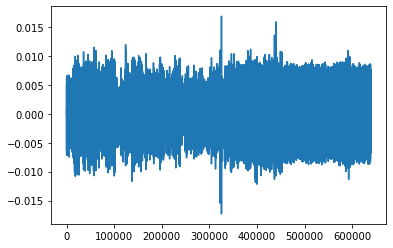

In [11]:
plt.plot(list(itertools.chain.from_iterable(samples)))
plt.show()

In [12]:
X_train = []
Y_train = []
for i in range(len(samples)-1):
    Y_train.append(True)
    first_half = list(samples[i][-edge_size:])
    last_half = list(samples[i + 1][:edge_size])
    X_train.append(first_half+last_half)
    if(i < len(samples)-2):
        Y_train.append(True)
        sec_last_half = list(samples[i + 2][:edge_size])
        X_train.append(first_half+sec_last_half)

In [13]:
min(map(len, X_train))

342

In [14]:
len(X_train)

471

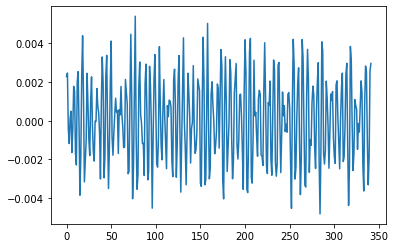

In [15]:
plt.plot(X_train[1])
plt.show()

In [16]:
from numpy import random

def get_strange_end_part(samples, current_index, max_len):
    x = random.randint(max_len-1)
    if (x != current_index+1) and (x != current_index+2):
        return list(samples[x][:edge_size])
    else:
        return get_strange_end_part(samples, current_index, max_len)


for i in range(len(samples)-1):
    first_half = list(samples[i][-edge_size:])
    last_half = get_strange_end_part(samples, i, len(samples))
    X_train.append(first_half+last_half)
    Y_train.append(False)
    sec_last_half = get_strange_end_part(samples, i, len(samples))
    X_train.append(first_half+sec_last_half)
    Y_train.append(False)

In [17]:
len(X_train)

943

In [18]:
min(map(len, X_train))

342

In [19]:
X_train = np.array(X_train)
X_train = X_train.reshape(-1, 2*edge_size)
X_train.shape

(943, 342)

In [20]:
Y_train = np.array(Y_train)
Y_train = Y_train.reshape(-1, 1)
Y_train.shape

(943, 1)

In [21]:
from keras.layers import Conv1D, LSTM, Flatten, CuDNNLSTM
from tensorflow.keras.optimizers import SGD

model = Sequential()
model.add(Conv1D(filters=512, kernel_size=2, input_shape=(2*edge_size, 1))) # 2 # 3 / filters 512
model.add(CuDNNLSTM(512, return_sequences=True)) # 256 # 8 #512 #256
model.add(Dense(512))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) #1 'rmsprop' 2 'adam' 3 SGD(learning_rate=0.01)
model.summary()

2022-06-24 14:29:43.202235: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-24 14:29:43.814176: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9634 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:05:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 341, 512)          1536      
                                                                 
 cu_dnnlstm (CuDNNLSTM)      (None, 341, 512)          2101248   
                                                                 
 dense (Dense)               (None, 341, 512)          262656    
                                                                 
 flatten (Flatten)           (None, 174592)            0         
                                                                 
 dense_1 (Dense)             (None, 1)                 174593    
                                                                 
Total params: 2,540,033
Trainable params: 2,540,033
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.fit(X_train, Y_train, epochs=100, batch_size=32) 
# batch size 8
#3s 21ms/step - loss: 0.6818 - accuracy: 0.5719
# 3s 21ms/step - loss: 0.7044 - accuracy: 0.5729
# 3s 21ms/step - loss: 0.6933 - accuracy: 0.4747
# 2s 17ms/step - loss: 0.6923 - accuracy: 0.5574
# 3s 29ms/step - loss: 0.6837 - accuracy: 0.5667
#121/121 [==============================] - 4s 30ms/step - loss: 0.6872 - accuracy: 0.5595 filters 512 , lstm 512

#batch size 64
# 2s 117ms/step - loss: 0.6428 - accuracy: 0.5957
#16/16 [==============================] - 2s 114ms/step - loss: 0.6905 - accuracy: 0.5522 -> kernel 4 lstm 512
# 16/16 [==============================] - 2s 115ms/step - loss: 0.6914 - accuracy: 0.5429 kernel 3 lstm 512
# 16/16 [==============================] - 2s 134ms/step - loss: 0.6446 - accuracy: 0.6070 kernel 2 lstm 512 filters 512
# Epoch 1000/1000
# 16/16 [==============================] - 2s 131ms/step - loss: 0.5504 - accuracy: 0.6856

#batch size 32
#  1s 46ms/step - loss: 0.7023 - accuracy: 0.5553

#batch size 128
#1s 92ms/step - loss: 0.6887 - accuracy: 0.5346



Epoch 1/100


2022-06-24 14:29:45.996118: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 7605
2022-06-24 14:29:45.997566: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-06-24 14:29:45.998215: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-06-24 14:29:45.998238: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-06-24 14:29:45.998654: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-06-24 14:29:45.998716: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


30/30 [==============================] - 10s 161ms/step - loss: 1.3294 - accuracy: 0.5143
Epoch 2/100
30/30 [==============================] - 1s 36ms/step - loss: 0.7066 - accuracy: 0.4836
Epoch 3/100
30/30 [==============================] - 1s 35ms/step - loss: 0.7569 - accuracy: 0.4867
Epoch 4/100
30/30 [==============================] - 1s 35ms/step - loss: 0.8127 - accuracy: 0.4952
Epoch 5/100
30/30 [==============================] - 1s 35ms/step - loss: 0.7217 - accuracy: 0.5037
Epoch 6/100
30/30 [==============================] - 1s 35ms/step - loss: 0.7327 - accuracy: 0.5133
Epoch 7/100
30/30 [==============================] - 1s 35ms/step - loss: 0.6993 - accuracy: 0.5037
Epoch 8/100
30/30 [==============================] - 1s 35ms/step - loss: 0.7706 - accuracy: 0.4931
Epoch 9/100
30/30 [==============================] - 1s 36ms/step - loss: 0.7161 - accuracy: 0.4857
Epoch 10/100
30/30 [==============================] - 1s 35ms/step - loss: 0.7898 - accuracy: 0.4899
Epoch 11/

In [23]:
example_x_train = X_train[-2]
example_x_train = example_x_train.reshape(1, 2*edge_size)
model.predict(example_x_train) 
#array([[0.40588772]], dtype=float32)
# array([[0.38362142]], dtype=float32)
# array([[0.49879223]], dtype=float32)
# array([[0.32653403]], dtype=float32)

array([[0.42719698]], dtype=float32)

In [24]:
example_x_train = X_train[1]
example_x_train = example_x_train.reshape(1, 2*edge_size)
model.predict(example_x_train) 
#array([[0.66257244]], dtype=float32)
#array([[0.72944134]], dtype=float32)
#array([[0.4988544]], dtype=float32)
#array([[0.63189554]], dtype=float32)

array([[0.4098465]], dtype=float32)

In [25]:
#Forschungsfragen
#› Lässt sich ein „hörbarer“ Musikstream erzeugen?
#› Reicht das stochastische Sampling? Wie lange ist eine optimale Sampledauer?
#› Wie ähnlich müssen sich die Urspungstracks bezüglich Stimmung, Genre, etc sein?
#› Müssen Metadaten wie Lautstärke, Tempo, Spektrum, etc mit einbezogen werden?